# Prerequesites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('/home/ibrahim/jupyter/models/pm2_predict/City_Types.csv')
pd.set_option('display.max_columns', None)
df.head()

,Date,City,CO,NO2,SO2,O3,PM2.5,PM10,Type
0,2024-01-01 00:00:00+00:00,Moscow,208.0,15.9,13.2,44.0,8.6,9.4,Industrial
1,2024-01-01 01:00:00+00:00,Moscow,207.0,17.4,13.7,44.0,8.6,10.5,Industrial
2,2024-01-01 02:00:00+00:00,Moscow,217.0,19.0,15.5,43.0,10.4,12.9,Industrial
3,2024-01-01 03:00:00+00:00,Moscow,231.0,21.0,20.7,36.0,12.3,15.3,Industrial
4,2024-01-01 04:00:00+00:00,Moscow,263.0,34.5,27.2,27.0,13.6,20.0,Industrial


# Data Assessing & Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52704 entries, 0 to 52703
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    52704 non-null  object 
 1   City    52704 non-null  object 
 2   CO      52704 non-null  float64
 3   NO2     52704 non-null  float64
 4   SO2     52704 non-null  float64
 5   O3      52704 non-null  float64
 6   PM2.5   52704 non-null  float64
 7   PM10    52704 non-null  float64
 8   Type    52704 non-null  object 
dtypes: float64(6), object(3)
memory usage: 3.6+ MB


In [4]:
df['Type'] = df['Type'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52704 entries, 0 to 52703
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Date    52704 non-null  object  
 1   City    52704 non-null  object  
 2   CO      52704 non-null  float64 
 3   NO2     52704 non-null  float64 
 4   SO2     52704 non-null  float64 
 5   O3      52704 non-null  float64 
 6   PM2.5   52704 non-null  float64 
 7   PM10    52704 non-null  float64 
 8   Type    52704 non-null  category
dtypes: category(1), float64(6), object(2)
memory usage: 3.3+ MB


# Exploratory Analysis

In [5]:
df.describe()

,CO,NO2,SO2,O3,PM2.5,PM10
count,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000
mean,508.030472,29.616492,22.387250,53.423668,32.931045,50.644980
std,692.274824,23.984409,34.285823,42.225556,43.833691,67.311502
min,0.000000,0.900000,0.000000,0.000000,0.300000,0.400000
25%,187.000000,11.000000,0.700000,26.000000,6.400000,9.400000
50%,268.000000,23.300000,10.500000,48.000000,14.800000,19.800000
75%,519.000000,42.200000,30.200000,69.000000,42.600000,68.350000
max,12876.000000,218.000000,497.800000,342.000000,459.100000,661.200000


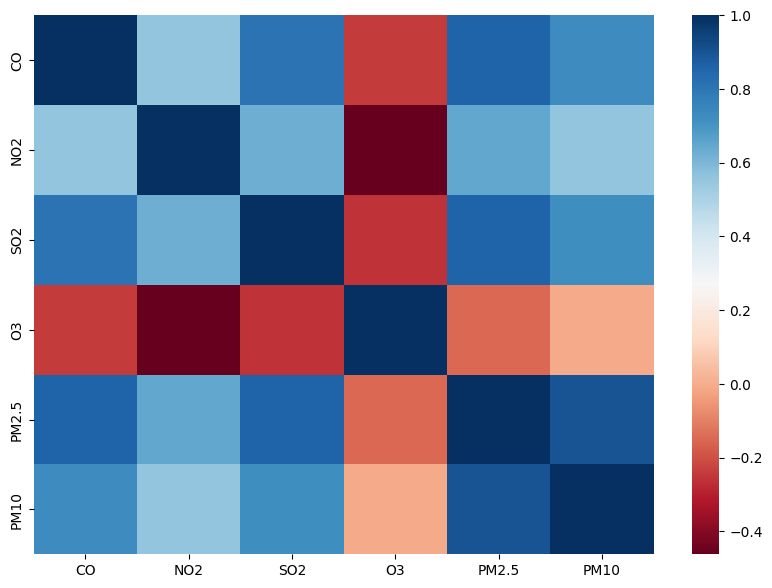

In [6]:
df_corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,7))
sns.heatmap(df_corr, cmap='RdBu')
plt.show()

In [7]:
features = df[['CO', 'NO2', 'SO2', 'O3']]
label = df[['PM2.5']]

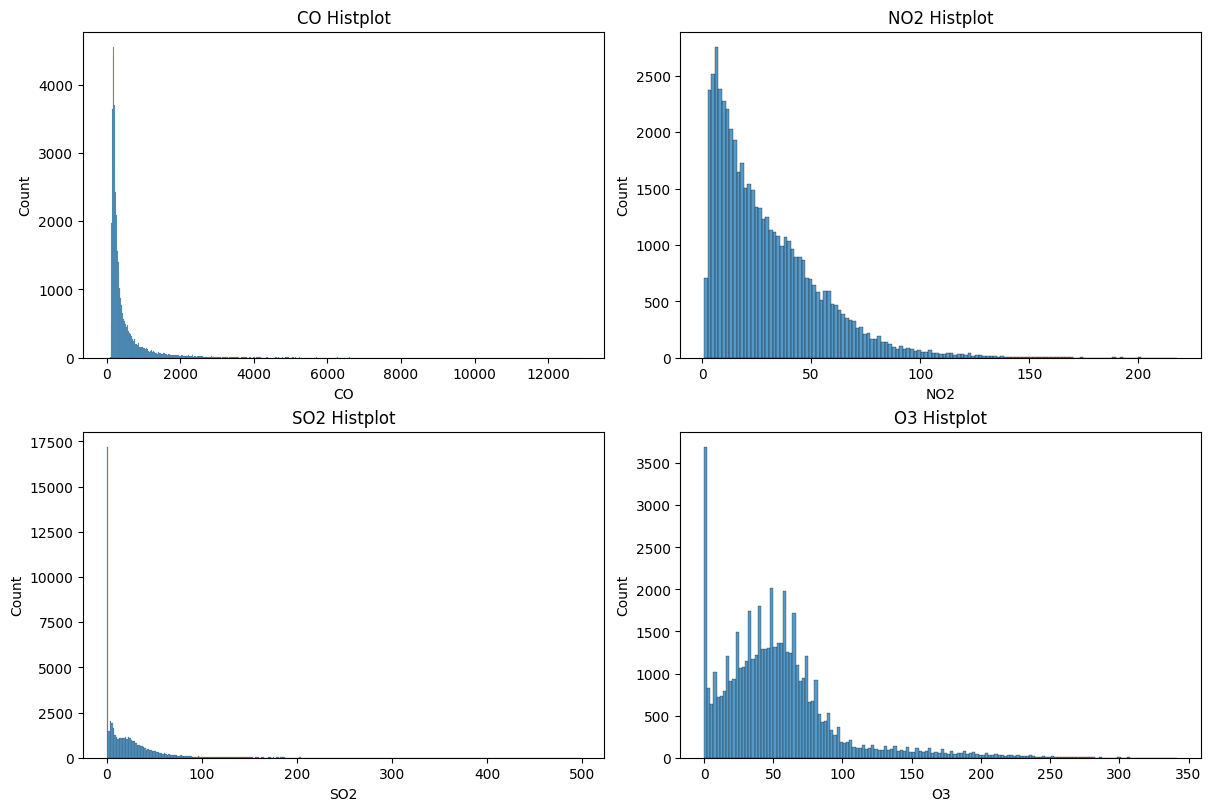

In [8]:
fig, axes = plt.subplots(2,2, constrained_layout=True, figsize=(12,8))
axes = axes.flatten()

feature_names = features.columns

for i, col in enumerate(feature_names):
    sns.histplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'{col} Histplot')

## Handling Outliers

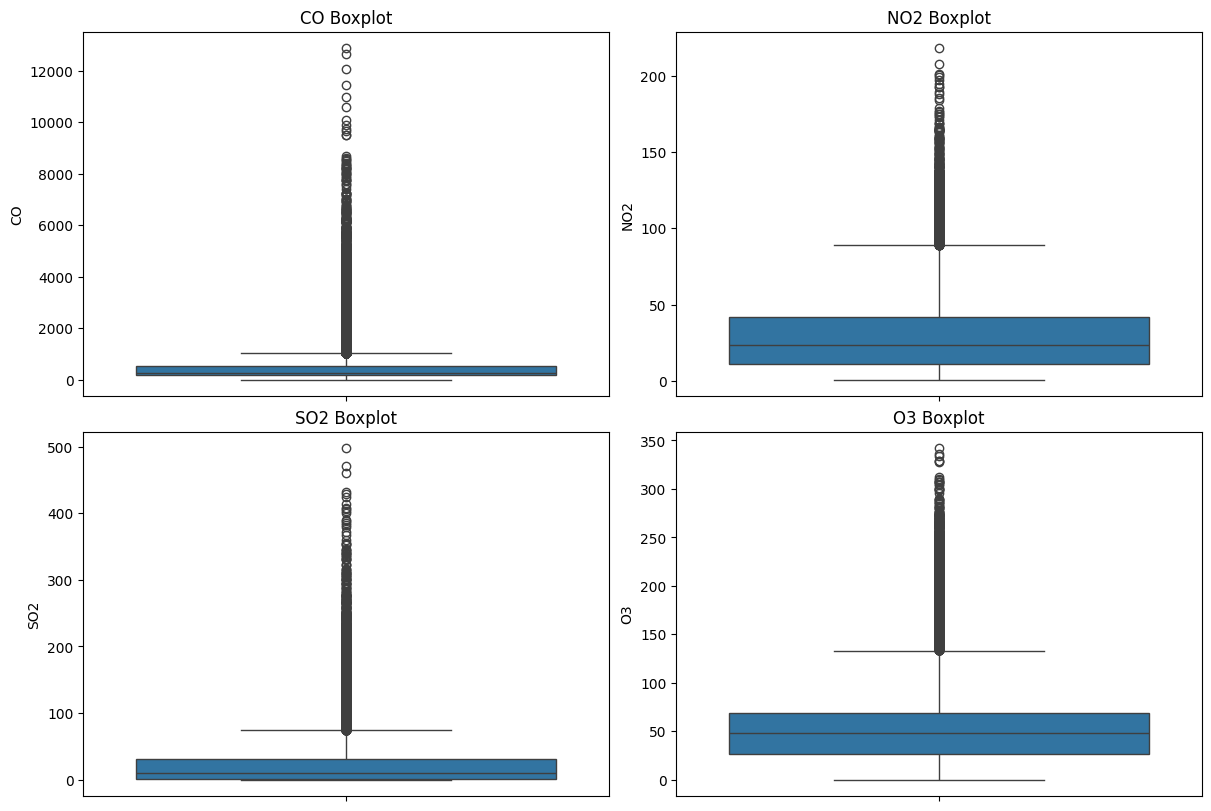

In [9]:
fig, axes = plt.subplots(2,2, constrained_layout=True, figsize=(12,8))
axes = axes.flatten()

feature_names = features.columns

for i, col in enumerate(feature_names):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'{col} Boxplot')

In [10]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    print(f'{column} IQR value: {IQR}')

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df[column]

print(f'Dataset size before outliers handled: {df.size}')
print(f'Dataset NaN values before outliers handled: {df.isna().sum().sum()}\n')

df['CO'] = handle_outliers(df, 'CO')
df['SO2'] = handle_outliers(df, 'SO2')
df['NO2'] = handle_outliers(df, 'NO2')
df['O3'] = handle_outliers(df, 'O3')

print(f'\nDataset NaN values after outliers handled: {df.isna().sum().sum()}')

print('Removing NaN values...', end='')
df.dropna(inplace=True)
print('Done!')
print(f'Dataset size after outliers handled: {df.size}')

Dataset size before outliers handled: 474336
Dataset NaN values before outliers handled: 0

CO IQR value: 332.0
SO2 IQR value: 29.5
NO2 IQR value: 31.200000000000003
O3 IQR value: 43.0

Dataset NaN values after outliers handled: 13191
Removing NaN values...Done!
Dataset size after outliers handled: 388647


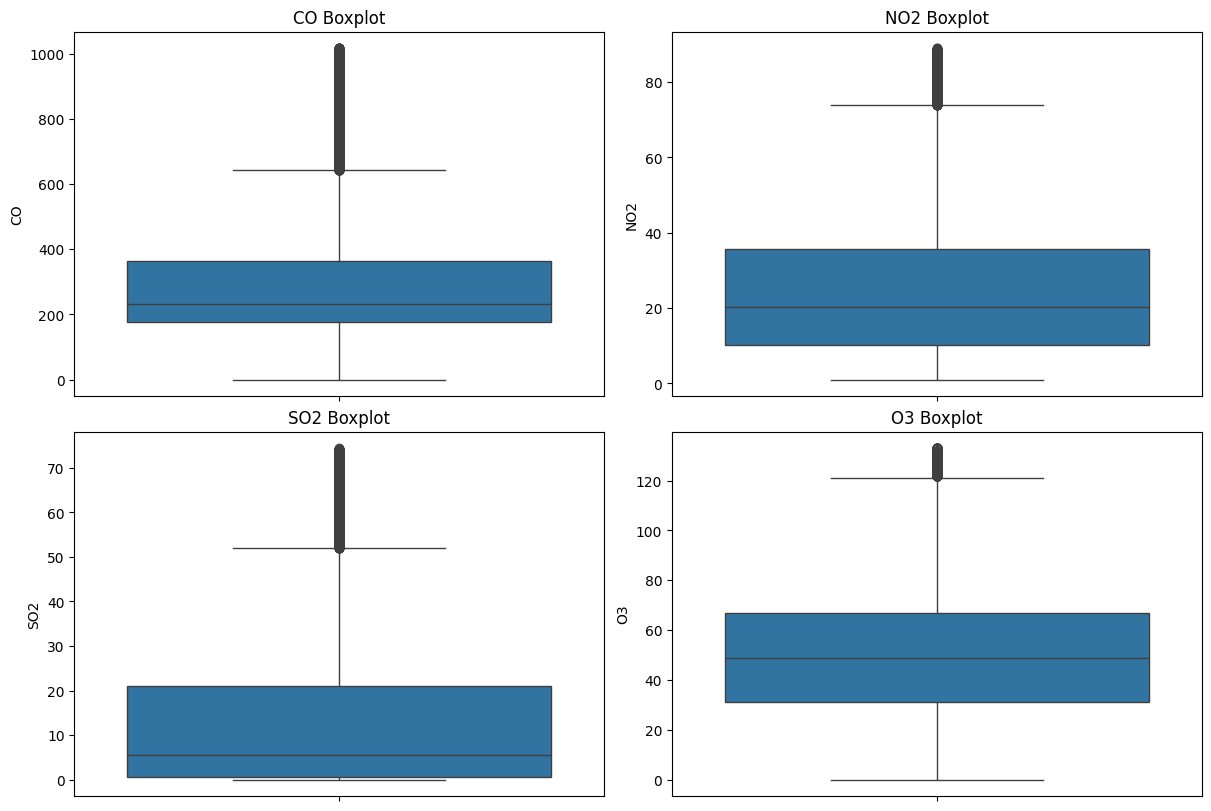

In [11]:
fig, axes = plt.subplots(2,2, constrained_layout=True, figsize=(12,8))
axes = axes.flatten()

feature_names = features.columns

for i, col in enumerate(feature_names):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'{col} Boxplot')

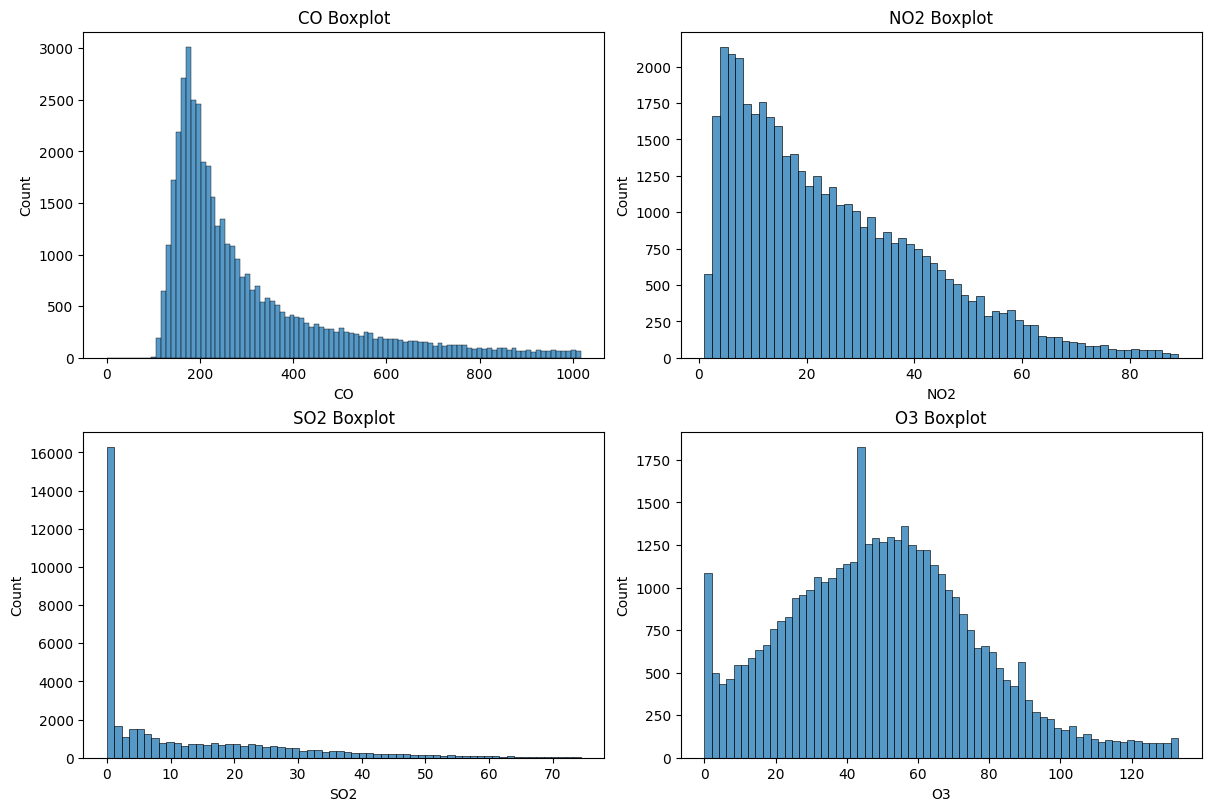

In [12]:
fig, axes = plt.subplots(2,2, constrained_layout=True, figsize=(12,8))
axes = axes.flatten()

feature_names = features.columns

for i, col in enumerate(feature_names):
    sns.histplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'{col} Boxplot')

# Determining the best model

In [13]:
models = {
    "LinearSVR": LinearSVR(),
    "ElasticNet": ElasticNet(),
    "LinearRegression": LinearRegression()
}

features = df[['CO', 'NO2', 'SO2', 'O3']]
label = df[['PM2.5']]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=44)

results = {}
mae_metrics = {}
mse_metrics = {}
r2_metrics = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mae_metrics[name] = mae
    mse_metrics[name] = mse
    r2_metrics[name] = r2

    print(f"{name} MAE: {mae:.2f}")
    print(f"{name} MSE: {mse:.2f}")
    print(f"{name} R2 Score: {r2:.2f}\n")

/home/ibrahim/jupyter/venv_lab/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVR MAE: 9.05
LinearSVR MSE: 205.25
LinearSVR R2 Score: 0.47

ElasticNet MAE: 5.93
ElasticNet MSE: 97.85
ElasticNet R2 Score: 0.75

LinearRegression MAE: 5.94
LinearRegression MSE: 97.86
LinearRegression R2 Score: 0.75



/home/ibrahim/jupyter/venv_lab/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Tuning parameters for the best model

In [14]:
def tune_elasticnet(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

    en_classifier = ElasticNet()

    param_grid = {
        'alpha': [1.0, 0.5, 1.5],
        'tol': [0.00001, 0.0001, 0.001],
        'max_iter': [1000, 500, 2000],
        'l1_ratio': [0.5, 0.7, 0.3]
    }

    grid_search = GridSearchCV(estimator=en_classifier, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Best model : {best_model}\n')
    print(f'Best parameter : {best_params}\n')
    print(f'MAE : {mae}\n')
    print(f'MSE : {mse}\n')
    print(f'R2 Score : {r2}\n')

    return best_model, best_params, mae, mse, r2

In [15]:
best_model, best_params, mae, mse, r2 = tune_elasticnet(features, label)

Best model : ElasticNet(alpha=0.5, l1_ratio=0.3, tol=1e-05)

Best parameter : {'alpha': 0.5, 'l1_ratio': 0.3, 'max_iter': 1000, 'tol': 1e-05}

MAE : 5.935379861230097

MSE : 98.09173971091263

R2 Score : 0.7503852949167554



 MAE: 5.94
 MSE: 98.09
 R2 Score: 0.75



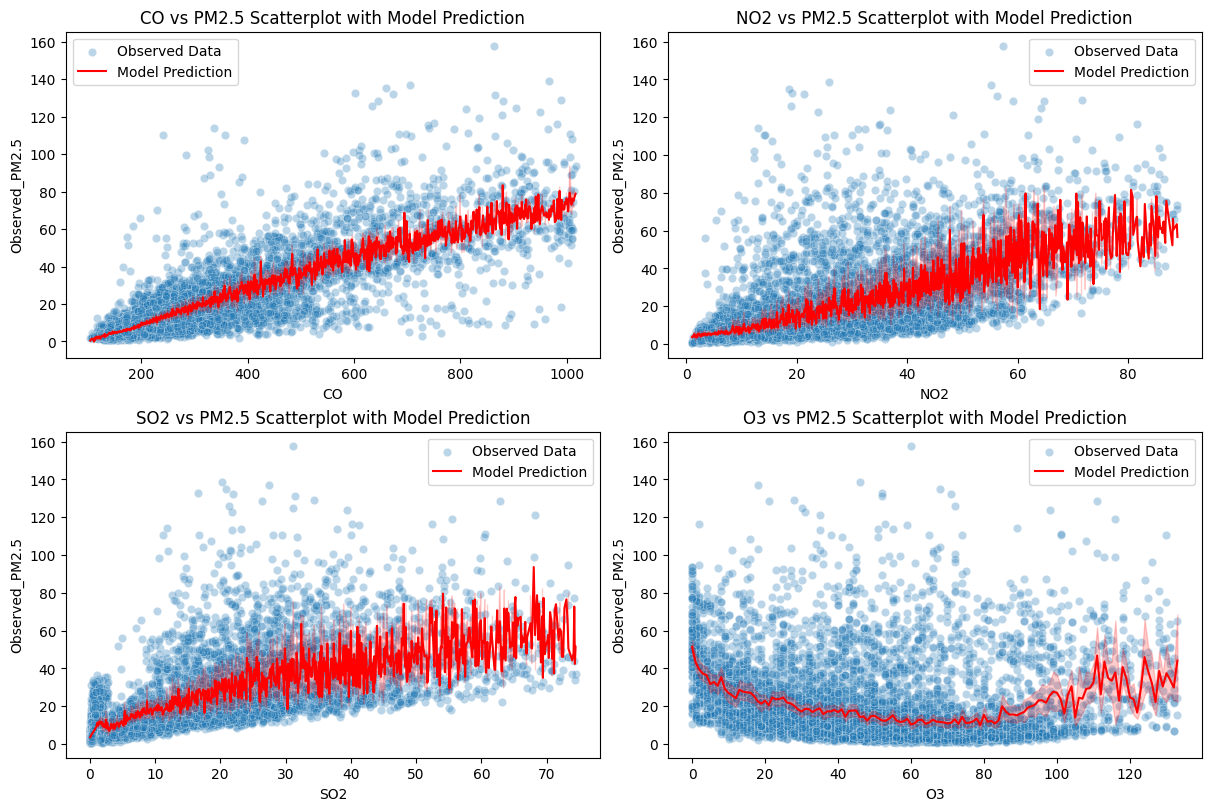

In [11]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv('/home/ibrahim/jupyter/models/pm2_predict/data_preprocessed.csv')

# Ensure Date is datetime for correct sorting/plotting
df['Date'] = pd.to_datetime(df['Date'])

features = df[['CO', 'NO2', 'SO2', 'O3']]
label = df[['PM2.5']]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=44)

model = ElasticNet(alpha=0.5, l1_ratio=0.3, max_iter=1000, tol=1e-05)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f" MAE: {mae:.2f}")
print(f" MSE: {mse:.2f}")
print(f" R2 Score: {r2:.2f}\n")

# Align predictions with their corresponding dates and sort by date
y_pred_df = X_test
y_pred_df['Predicted_PM2.5'] = y_pred
y_pred_df['Observed_PM2.5'] = y_test

fig, axes = plt.subplots(2,2, constrained_layout=True, figsize=(12,8))
axes = axes.flatten()

feature_names = features.columns

with open('metrics.json', 'w') as outfile:
    json.dump({ "mae": mae, "mse": mse, "r2_score": r2 }, outfile)


for i, col in enumerate(feature_names):
    sns.scatterplot(data=y_pred_df, x=col, y='Observed_PM2.5', alpha=0.3, label='Observed Data', ax=axes[i])
    sns.lineplot(data=y_pred_df, x=col, y='Predicted_PM2.5', color='red', label='Model Prediction', ax=axes[i])
    axes[i].set_title(f'{col} vs PM2.5 Scatterplot with Model Prediction')

fig.savefig('scatterplot_with_prediction.png', dpi=100)

# plt.figure(figsize=(12,8))
# sns.scatterplot(data=y_pred_df, x='CO', y='Observed_PM2.5', alpha=0.3, label='Observed Data')
# sns.lineplot(data=y_pred_df, x='CO', y='Predicted_PM2.5', color='red', label='Model Prediction')
# plt.title('PM2.5 vs CO with Predicted Line')
# plt.xlabel('CO')
# plt.xticks([])
# plt.ylabel('PM2.5 Value')
# plt.legend()
# plt.show()